In [1]:
#from seaborn import load_dataset
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from sklearn.model_selection import StratifiedKFold
from julearn.viz import plot_scores
from junifer.storage import HDF5FeatureStorage
from nilearn import datasets, plotting
import numpy as np
import pandas as pd
import os                                                                   
import glob  

# Leyendo features de FC

Leemos todos los features de FC (para Schaefer100x17 y CogAr spheres) en un dataframe ordenados por $(sub_i, run_j, block_k)$ i=1...16, j=1...5, k=0...11, 

In [2]:
# Order files by (#sub, #run, #block)
def get_key(fp):
    filename = os.path.splitext(os.path.basename(fp))[0]
    split = filename.split("_")
    return (int(split[1]), int(split[2]), int(split[3]))

In [3]:
df_parcellation = None
df_spheres = None
for file in (list(sorted(glob.glob('../Features/ds003548/*.hdf5'),key=get_key))):                                       
    storage = HDF5FeatureStorage(file)
    df = storage.read_df("BOLD_FC-Parcellation-Schaefer100x17")
    df_parcellation = pd.concat([df_parcellation, df])
    df = storage.read_df("BOLD_FC-CogAR-5mm")
    df_spheres = pd.concat([df_spheres, df])
    
assert(len(df_parcellation) == 960)
assert(len(df_spheres) == 960)

KeyboardInterrupt: 

## Matrices de correlación

In [4]:
# Veamos una muestra
fc = df_parcellation.iloc[6]
correlation_matrix = np.zeros((100,100))
lower_ix = np.tril_indices(100)
correlation_matrix[lower_ix] = fc
assert(np.all(np.abs(correlation_matrix) <= 1))

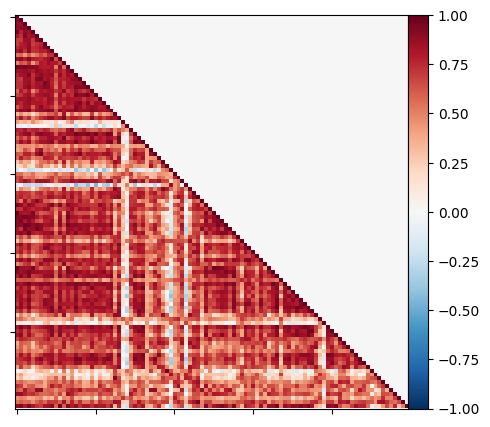

In [5]:
plotting.plot_matrix(
    correlation_matrix,
    figure=(5, 5),
    vmax=1,
    vmin=-1,
    # title="Correlation",
    #tri="full"
)

In [50]:
emos = ["happy", "sad", "angry", "neutral"]
df_trial_type = None
for nruns in range(1,6):
    _ = pd.read_csv(f"task-emotionalfaces_run-{nruns}_events.tsv", sep="\t")['trial_type'][:12]
    df_trial_type = pd.concat([df_trial_type, _])

12
12
12
12
12


In [59]:
df_parcellation["trial_type"] = pd.concat([df_trial_type] * 16).values

chunk  run  subject
0      1    01             blank
1      1    01         scrambled
2      1    01             happy
3      1    01               sad
4      1    01             angry
                         ...    
7      5    16               sad
8      5    16             happy
9      5    16           neutral
10     5    16             angry
11     5    16             blank
Name: trial_type, Length: 960, dtype: object

# Pipeline de clasificación binaria (basico)

Veamos un ejemplo de clasificación binaria happy vs sad

In [87]:
mask = (df_parcellation["trial_type"] == "happy") | (df_parcellation["trial_type"] == "sad")
df = df_parcellation[mask]
assert(len(df) == 320)

In [88]:
emo2ix = {'happy': 0, 'sad':1}
df['trial_type'] = df['trial_type'].apply(lambda x: emo2ix[x])

/tmp/ipykernel_27605/2693866098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trial_type'] = df['trial_type'].apply(lambda x: emo2ix[x])


,,,LH_VisCent_ExStr_1~LH_VisCent_ExStr_1,LH_VisCent_ExStr_2~LH_VisCent_ExStr_1,LH_VisCent_ExStr_2~LH_VisCent_ExStr_2,LH_VisCent_Striate_1~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_2,LH_VisCent_Striate_1~LH_VisCent_Striate_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_Striate_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_3,...,RH_TempPar_3~RH_DefaultA_PFCm_1,RH_TempPar_3~RH_DefaultB_PFCd_1,RH_TempPar_3~RH_DefaultB_PFCv_1,RH_TempPar_3~RH_DefaultB_PFCv_2,RH_TempPar_3~RH_DefaultC_Rsp_1,RH_TempPar_3~RH_DefaultC_PHC_1,RH_TempPar_3~RH_TempPar_1,RH_TempPar_3~RH_TempPar_2,RH_TempPar_3~RH_TempPar_3,trial_type
chunk,run,subject,,,,,,,,,,,,,,,,,,,,,
2,1,01,1.0,0.973118,1.0,0.952041,0.985969,1.0,0.923570,0.966155,0.946785,1.0,...,0.481572,0.667208,0.456480,0.781799,0.683478,0.517594,0.729485,0.659463,1.0,0
3,1,01,1.0,0.961369,1.0,0.963875,0.970901,1.0,0.899249,0.930340,0.927190,1.0,...,0.853049,0.650359,0.843399,0.863763,0.487398,0.196847,0.805759,0.865798,1.0,1
6,1,01,1.0,0.899392,1.0,0.876793,0.852928,1.0,0.872348,0.897082,0.906387,1.0,...,0.205342,0.195905,0.434483,0.671794,0.489661,0.764407,0.282469,0.506765,1.0,0
7,1,01,1.0,0.863560,1.0,0.935700,0.948687,1.0,0.795741,0.896433,0.878481,1.0,...,0.268322,0.352960,-0.226962,0.647916,0.466320,0.098751,0.370969,0.161312,1.0,1
0,2,01,1.0,0.971359,1.0,0.892965,0.915775,1.0,0.883339,0.906697,0.931216,1.0,...,0.342465,0.392212,0.420127,0.887184,0.481013,0.255990,0.586464,0.795877,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,4,16,1.0,0.554278,1.0,0.823312,0.523807,1.0,0.852675,0.779486,0.759696,1.0,...,0.473552,0.639306,0.618318,0.762899,0.864426,0.774149,0.818687,0.913161,1.0,1
1,5,16,1.0,0.848807,1.0,0.684934,0.877927,1.0,0.776021,0.771211,0.814108,1.0,...,0.622642,0.793668,0.799864,0.772513,0.895831,0.873940,0.861635,0.781456,1.0,1
2,5,16,1.0,0.829915,1.0,0.646930,0.644992,1.0,0.411229,0.218857,0.756596,1.0,...,0.567867,0.564901,0.590886,0.678876,0.905493,0.513862,0.712200,0.862996,1.0,0


In [90]:
df.columns = df.columns.astype(str)
X = list(df.columns)

In [100]:
creator1 = PipelineCreator(problem_type="classification")
#creator1.add("zscore")
creator1.add("svm", kernel=["rbf", "sigmoid"], gamma=np.logspace(-1,3,3), C=[.001,.01,0.1,1,10,100])

In [104]:
y = "trial_type"
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

In [105]:
scores1, model, inspector = run_cross_validation(
    X = X,
    y = y,
    data = df,
    model = creator1,
    cv = cv,
    return_train_score=True,
    return_inspector=True,
    scoring=["accuracy"]
)

The dataframe has 5051 columns. Checking X for consistency might take a while. To skip this checks, set the config flag `disable_x_check` to `True`.
/home/nicolas/.pyenv/versions/3.8.10/envs/asterix/lib/python3.8/site-packages/julearn/prepare.py:195: RuntimeWarning: The dataframe has 5051 columns. Checking X for consistency might take a while. To skip this checks, set the config flag `disable_x_check` to `True`.
  warn_with_log(
List of features (X) contains the target trial_type
/home/nicolas/.pyenv/versions/3.8.10/envs/asterix/lib/python3.8/site-packages/julearn/prepare.py:127: RuntimeWarning: List of features (X) contains the target trial_type
  warn_with_log(f"List of features (X) contains the target {y}")
X has 5051 columns. Checking X_types for consistency might take a while. To skip this checks, set the config flag `disable_xtypes_check` to `True`.
/home/nicolas/.pyenv/versions/3.8.10/envs/asterix/lib/python3.8/site-packages/julearn/prepare.py:467: RuntimeWarning: X has 5051 col

In [106]:
scores1

,fit_time,score_time,estimator,test_accuracy,train_accuracy,n_train,n_test,repeat,fold,cv_mdsum
0,17.008353,0.051748,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.484375,1.0,256,64,0,0,4bbff3df81cf8854822a1b557f37a710
1,16.975067,0.052795,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.500000,1.0,256,64,0,1,4bbff3df81cf8854822a1b557f37a710
2,16.975044,0.052044,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.500000,1.0,256,64,0,2,4bbff3df81cf8854822a1b557f37a710
3,16.979445,0.052262,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.546875,1.0,256,64,0,3,4bbff3df81cf8854822a1b557f37a710
4,17.009226,0.052236,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.515625,1.0,256,64,0,4,4bbff3df81cf8854822a1b557f37a710


In [102]:
scores1['estimator']

0    GridSearchCV(cv=KFold(n_splits=5, random_state...
1    GridSearchCV(cv=KFold(n_splits=5, random_state...
2    GridSearchCV(cv=KFold(n_splits=5, random_state...
3    GridSearchCV(cv=KFold(n_splits=5, random_state...
4    GridSearchCV(cv=KFold(n_splits=5, random_state...
Name: estimator, dtype: object

In [103]:
for i in range(5):
    print(scores1['estimator'][i].best_params_)

{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
{'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
{'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
{'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
{'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [97]:
model.best_params_

{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

In [98]:
import pandas as pd
for i in range(5):
    print(pd.DataFrame((scores1['estimator'])[i].cv_results_))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_svm__C  \
0        0.064472      0.000394         0.040399        0.000711          0.1   
1        0.062754      0.000182         0.027164        0.000089          0.1   
2        0.063436      0.000313         0.039732        0.000211          0.1   
3        0.062833      0.000269         0.027186        0.000150          0.1   
4        0.063575      0.000405         0.039997        0.000235          0.1   
5        0.062650      0.000201         0.027233        0.000175          0.1   
6        0.064068      0.000235         0.040733        0.000766            1   
7        0.062845      0.000179         0.027356        0.000121            1   
8        0.063995      0.000844         0.040343        0.000665            1   
9        0.062969      0.000285         0.027323        0.000187            1   
10       0.063764      0.000395         0.040095        0.000207            1   
11       0.063182      0.000

Column
    [0] Row
        [0] PNG(str, width=200)
        [1] Spacer(width=50)
        [2] Markdown(str)
    [1] Row
        [0] Param(_JulearnScoresViewer, name='Metric', parameters=['metric'], widgets={'metric': {'type': <class...})
        [1] Param(_JulearnScoresViewer, name='Statistics', parameters=['show_stats'], widgets={'show_stats': {'type': <c...})
        [2] Param(_JulearnScoresViewer, name='Aggregate Repeats', parameters=['group_repeats'], widgets={'group_repeats': {'type':...})
    [2] Row
        [0] ParamMethod(method, _pane=Bokeh, defer_load=False)
        [1] Column
            [0] Param(_JulearnScoresViewer, name='Sets', parameters=['sets'], widgets={'sets': {'type': <class '...})
            [1] Param(_JulearnScoresViewer, name='Models', parameters=['models'], widgets={'models': {'type': <class...})
    [3] ParamMethod(method, _pane=Markdown, defer_load=False)
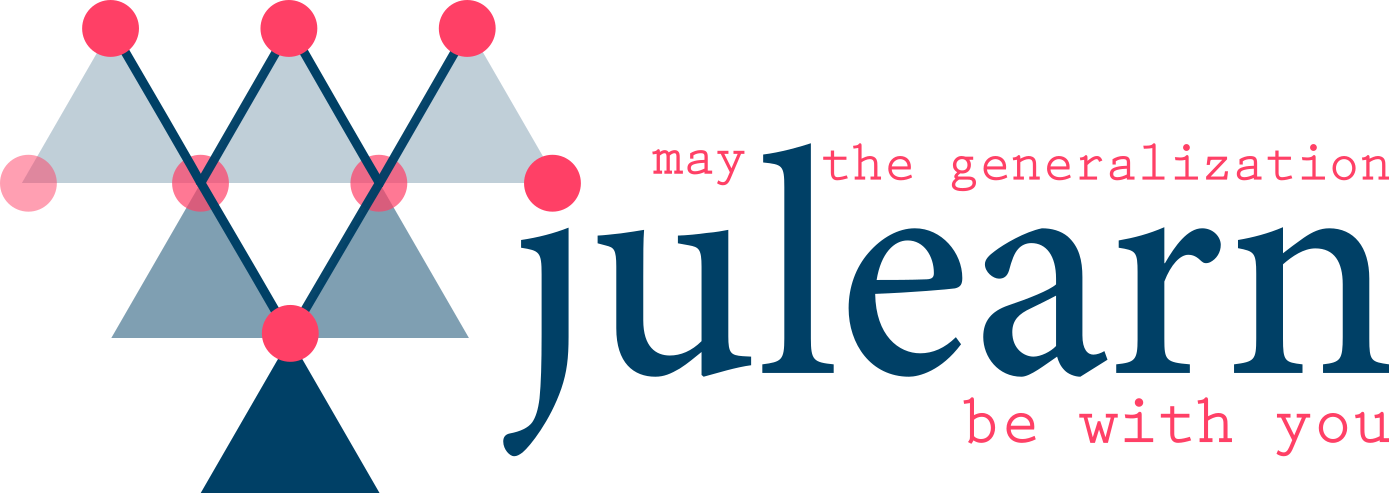

In [12]:
plot_scores(scores1)